# Initialize

In [1]:
#@title Import {display-mode: "form"}
import math
import torch
from torch import nn

# Model

In [2]:
#@title Swish {display-mode: "form"}
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [3]:
#@title FeatureEx1d {display-mode: "form"}
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [4]:
#@title SEblock {display-mode: "form"}
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [5]:
#@title ConvBNFirst {display-mode: "form"}
class ConvBNFirst(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size=(3, 257//3), stride=(1, 257//6), padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [6]:
#@title ConvBN {display-mode: "form"}
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [7]:
#@title DropConnect {display-mode: "form"}
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [8]:
#@title BMConvBlock {display-mode: "form"}
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [9]:
#@title Flatten {display-mode: "form"}
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [10]:
#@title MultiModalNet {display-mode: "form"}
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_1d_features=10,
               num_classes=4,
               input_ch=3):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBNFirst(input_ch, ch_out), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

    self.features1d = nn.Sequential(
        nn.Linear(num_1d_features, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features1d(x[0])
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)

    return x

# Dataset

In [11]:
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"

In [12]:
import shutil
import os


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/5s_0.5shift/pickles1/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 9200
Q2 9200
Q3 9200
Q4 9200
Q1 9200
Q2 9200
Q3 9200
Q4 9200


In [13]:
import os
def make_filepath_list(root, train_rate=0.8):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)


      for f in file_list:
        split_num = int(f.split(".")[1].split("_")[-1])
        if split_num % 5 == 4:
          valid_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))
        else:
          train_file_list.append(os.path.join(root, dirs, f).replace('\\', '/'))

  
  return train_file_list, valid_file_list


In [14]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  29600
/content/datas/Q3/Q3.MT0040033011_15.wav.pickle
検証データ数 :  7200
/content/datas/Q3/Q3.MT0009619048_14.wav.pickle
Dataset1 shape: torch.Size([26])
Dataset2 shape: torch.Size([1, 431, 257])
Dataset label: 2


# DataLoader

In [15]:
# バッチサイズの指定
batch_size = 32

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([32, 26])
torch.Size([32, 1, 431, 257])
tensor([2, 1, 1, 2, 0, 0, 3, 2, 2, 3, 2, 0, 0, 2, 1, 1, 0, 0, 0, 3, 0, 0, 2, 1,
        2, 0, 2, 3, 2, 2, 1, 1])


# Optimizer, Criterion

In [16]:
torch_clearlizer = False #@param {type: "boolean"}

if torch_clearlizer:
  del train_dataset
  del valid_dataset
  del train_dataloader
  del valid_dataloader
  del labels
  del loss_hist
  del acc_hist
  del optimizer
  del criterion
  torch.cuda.empty_cache()

In [17]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4, num_1d_features=train_dataset.__getitem__(index)[0][0].size(0)).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.1) 
criterion = nn.CrossEntropyLoss()

SGD -> じわっとloss減ってく


# Training

In [18]:
from tqdm import tqdm
# エポック数
num_epochs = 200


loss_hist = [[],[]]
acc_hist = [[],[]]

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 925/925 [02:31<00:00,  6.12batch/s, loss=1.15]


[train] Epoch 1 Result: Loss: 1.2389 Acc: 0.4768



[valid] Epoch 1: 100%|██████████| 225/225 [00:34<00:00,  6.50batch/s, loss=1.09]


[valid] Epoch 1 Result: Loss: 1.1462 Acc: 0.5763

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 925/925 [02:17<00:00,  6.72batch/s, loss=1.01]


[train] Epoch 2 Result: Loss: 1.1203 Acc: 0.6138



[valid] Epoch 2: 100%|██████████| 225/225 [00:32<00:00,  6.92batch/s, loss=1.07]


[valid] Epoch 2 Result: Loss: 1.0727 Acc: 0.6704

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 925/925 [02:18<00:00,  6.68batch/s, loss=0.897]


[train] Epoch 3 Result: Loss: 1.0629 Acc: 0.6767



[valid] Epoch 3: 100%|██████████| 225/225 [00:33<00:00,  6.76batch/s, loss=0.999]


[valid] Epoch 3 Result: Loss: 1.0596 Acc: 0.6781

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 925/925 [02:18<00:00,  6.67batch/s, loss=0.963]


[train] Epoch 4 Result: Loss: 1.0211 Acc: 0.7217



[valid] Epoch 4: 100%|██████████| 225/225 [00:32<00:00,  6.91batch/s, loss=1.02]


[valid] Epoch 4 Result: Loss: 1.0033 Acc: 0.7389

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 925/925 [02:17<00:00,  6.73batch/s, loss=0.981]


[train] Epoch 5 Result: Loss: 0.9883 Acc: 0.7538



[valid] Epoch 5: 100%|██████████| 225/225 [00:33<00:00,  6.63batch/s, loss=0.957]


[valid] Epoch 5 Result: Loss: 0.9716 Acc: 0.7714

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 925/925 [02:21<00:00,  6.53batch/s, loss=1.09]


[train] Epoch 6 Result: Loss: 0.9582 Acc: 0.7850



[valid] Epoch 6: 100%|██████████| 225/225 [00:33<00:00,  6.68batch/s, loss=0.914]


[valid] Epoch 6 Result: Loss: 0.9549 Acc: 0.7867

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 925/925 [02:51<00:00,  5.41batch/s, loss=1]


[train] Epoch 7 Result: Loss: 0.9347 Acc: 0.8079



[valid] Epoch 7: 100%|██████████| 225/225 [00:44<00:00,  5.08batch/s, loss=0.912]


[valid] Epoch 7 Result: Loss: 0.9132 Acc: 0.8287

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.945]


[train] Epoch 8 Result: Loss: 0.9191 Acc: 0.8240



[valid] Epoch 8: 100%|██████████| 225/225 [00:45<00:00,  4.94batch/s, loss=0.913]


[valid] Epoch 8 Result: Loss: 0.9135 Acc: 0.8294

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=1.05]


[train] Epoch 9 Result: Loss: 0.9041 Acc: 0.8392



[valid] Epoch 9: 100%|██████████| 225/225 [00:45<00:00,  4.94batch/s, loss=0.954]


[valid] Epoch 9 Result: Loss: 0.8957 Acc: 0.8476

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.903]


[train] Epoch 10 Result: Loss: 0.8874 Acc: 0.8559



[valid] Epoch 10: 100%|██████████| 225/225 [00:45<00:00,  4.93batch/s, loss=0.861]


[valid] Epoch 10 Result: Loss: 0.8818 Acc: 0.8618

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.896]


[train] Epoch 11 Result: Loss: 0.8719 Acc: 0.8714



[valid] Epoch 11: 100%|██████████| 225/225 [00:45<00:00,  4.96batch/s, loss=0.873]


[valid] Epoch 11 Result: Loss: 0.8566 Acc: 0.8876

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.846]


[train] Epoch 12 Result: Loss: 0.8671 Acc: 0.8762



[valid] Epoch 12: 100%|██████████| 225/225 [00:44<00:00,  5.10batch/s, loss=0.864]


[valid] Epoch 12 Result: Loss: 0.8472 Acc: 0.8974

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 925/925 [03:05<00:00,  4.99batch/s, loss=0.806]


[train] Epoch 13 Result: Loss: 0.8576 Acc: 0.8859



[valid] Epoch 13: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.897]


[valid] Epoch 13 Result: Loss: 0.8448 Acc: 0.8993

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 925/925 [03:05<00:00,  4.98batch/s, loss=0.873]


[train] Epoch 14 Result: Loss: 0.8474 Acc: 0.8959



[valid] Epoch 14: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.846]


[valid] Epoch 14 Result: Loss: 0.8343 Acc: 0.9099

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 925/925 [03:05<00:00,  4.99batch/s, loss=0.84]


[train] Epoch 15 Result: Loss: 0.8421 Acc: 0.9019



[valid] Epoch 15: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.801]


[valid] Epoch 15 Result: Loss: 0.8303 Acc: 0.9135

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.941]


[train] Epoch 16 Result: Loss: 0.8303 Acc: 0.9135



[valid] Epoch 16: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.797]


[valid] Epoch 16 Result: Loss: 0.8293 Acc: 0.9146

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.836]


[train] Epoch 17 Result: Loss: 0.8271 Acc: 0.9168



[valid] Epoch 17: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.838]


[valid] Epoch 17 Result: Loss: 0.8367 Acc: 0.9068

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.804]


[train] Epoch 18 Result: Loss: 0.8237 Acc: 0.9201



[valid] Epoch 18: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.815]


[valid] Epoch 18 Result: Loss: 0.8154 Acc: 0.9290

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.786]


[train] Epoch 19 Result: Loss: 0.8200 Acc: 0.9236



[valid] Epoch 19: 100%|██████████| 225/225 [00:44<00:00,  5.06batch/s, loss=0.778]


[valid] Epoch 19 Result: Loss: 0.8171 Acc: 0.9257

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.876]


[train] Epoch 20 Result: Loss: 0.8182 Acc: 0.9253



[valid] Epoch 20: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 20 Result: Loss: 0.8142 Acc: 0.9294

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.836]


[train] Epoch 21 Result: Loss: 0.8157 Acc: 0.9281



[valid] Epoch 21: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.789]


[valid] Epoch 21 Result: Loss: 0.8179 Acc: 0.9263

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.842]


[train] Epoch 22 Result: Loss: 0.8142 Acc: 0.9296



[valid] Epoch 22: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 22 Result: Loss: 0.8148 Acc: 0.9287

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.808]


[train] Epoch 23 Result: Loss: 0.8128 Acc: 0.9309



[valid] Epoch 23: 100%|██████████| 225/225 [00:45<00:00,  4.92batch/s, loss=0.775]


[valid] Epoch 23 Result: Loss: 0.8061 Acc: 0.9372

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.838]


[train] Epoch 24 Result: Loss: 0.8095 Acc: 0.9339



[valid] Epoch 24: 100%|██████████| 225/225 [00:44<00:00,  5.08batch/s, loss=0.79]


[valid] Epoch 24 Result: Loss: 0.8152 Acc: 0.9287

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 925/925 [03:04<00:00,  5.03batch/s, loss=0.775]


[train] Epoch 25 Result: Loss: 0.8053 Acc: 0.9381



[valid] Epoch 25: 100%|██████████| 225/225 [00:44<00:00,  5.09batch/s, loss=0.78]


[valid] Epoch 25 Result: Loss: 0.8003 Acc: 0.9439

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.744]


[train] Epoch 26 Result: Loss: 0.8036 Acc: 0.9401



[valid] Epoch 26: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.817]


[valid] Epoch 26 Result: Loss: 0.8031 Acc: 0.9404

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.775]


[train] Epoch 27 Result: Loss: 0.8015 Acc: 0.9424



[valid] Epoch 27: 100%|██████████| 225/225 [00:44<00:00,  5.06batch/s, loss=0.778]


[valid] Epoch 27 Result: Loss: 0.8085 Acc: 0.9353

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.775]


[train] Epoch 28 Result: Loss: 0.8023 Acc: 0.9410



[valid] Epoch 28: 100%|██████████| 225/225 [00:45<00:00,  4.96batch/s, loss=0.808]


[valid] Epoch 28 Result: Loss: 0.8089 Acc: 0.9350

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.806]


[train] Epoch 29 Result: Loss: 0.7995 Acc: 0.9441



[valid] Epoch 29: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.804]


[valid] Epoch 29 Result: Loss: 0.7941 Acc: 0.9493

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 925/925 [03:04<00:00,  5.00batch/s, loss=0.744]


[train] Epoch 30 Result: Loss: 0.7975 Acc: 0.9459



[valid] Epoch 30: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.776]


[valid] Epoch 30 Result: Loss: 0.7988 Acc: 0.9450

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.777]


[train] Epoch 31 Result: Loss: 0.7960 Acc: 0.9476



[valid] Epoch 31: 100%|██████████| 225/225 [00:44<00:00,  5.06batch/s, loss=0.775]


[valid] Epoch 31 Result: Loss: 0.8076 Acc: 0.9357

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.807]


[train] Epoch 32 Result: Loss: 0.7927 Acc: 0.9509



[valid] Epoch 32: 100%|██████████| 225/225 [00:45<00:00,  4.94batch/s, loss=0.777]


[valid] Epoch 32 Result: Loss: 0.7895 Acc: 0.9539

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.744]


[train] Epoch 33 Result: Loss: 0.7953 Acc: 0.9479



[valid] Epoch 33: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.824]


[valid] Epoch 33 Result: Loss: 0.7928 Acc: 0.9508

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 925/925 [03:05<00:00,  4.99batch/s, loss=0.839]


[train] Epoch 34 Result: Loss: 0.7917 Acc: 0.9520



[valid] Epoch 34: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 34 Result: Loss: 0.7886 Acc: 0.9547

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 925/925 [03:04<00:00,  5.03batch/s, loss=0.744]


[train] Epoch 35 Result: Loss: 0.7898 Acc: 0.9537



[valid] Epoch 35: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.777]


[valid] Epoch 35 Result: Loss: 0.7917 Acc: 0.9518

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 36 Result: Loss: 0.7876 Acc: 0.9560



[valid] Epoch 36: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.779]


[valid] Epoch 36 Result: Loss: 0.7872 Acc: 0.9563

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.775]


[train] Epoch 37 Result: Loss: 0.7907 Acc: 0.9529



[valid] Epoch 37: 100%|██████████| 225/225 [00:43<00:00,  5.18batch/s, loss=0.809]


[valid] Epoch 37 Result: Loss: 0.7899 Acc: 0.9537

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.803]


[train] Epoch 38 Result: Loss: 0.7903 Acc: 0.9533



[valid] Epoch 38: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.807]


[valid] Epoch 38 Result: Loss: 0.7972 Acc: 0.9461

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.818]


[train] Epoch 39 Result: Loss: 0.7906 Acc: 0.9529



[valid] Epoch 39: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 39 Result: Loss: 0.7870 Acc: 0.9563

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 40 Result: Loss: 0.7894 Acc: 0.9543



[valid] Epoch 40: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.775]


[valid] Epoch 40 Result: Loss: 0.7870 Acc: 0.9565

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.791]


[train] Epoch 41 Result: Loss: 0.7869 Acc: 0.9566



[valid] Epoch 41: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 41 Result: Loss: 0.7902 Acc: 0.9536

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.775]


[train] Epoch 42 Result: Loss: 0.7848 Acc: 0.9590



[valid] Epoch 42: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 42 Result: Loss: 0.7840 Acc: 0.9596

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.775]


[train] Epoch 43 Result: Loss: 0.7836 Acc: 0.9601



[valid] Epoch 43: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 43 Result: Loss: 0.7831 Acc: 0.9604

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 44 Result: Loss: 0.7839 Acc: 0.9597



[valid] Epoch 44: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.775]


[valid] Epoch 44 Result: Loss: 0.7830 Acc: 0.9607

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 45 Result: Loss: 0.7833 Acc: 0.9602



[valid] Epoch 45: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.778]


[valid] Epoch 45 Result: Loss: 0.7844 Acc: 0.9589

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.775]


[train] Epoch 46 Result: Loss: 0.7835 Acc: 0.9602



[valid] Epoch 46: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 46 Result: Loss: 0.7819 Acc: 0.9617

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.775]


[train] Epoch 47 Result: Loss: 0.7860 Acc: 0.9573



[valid] Epoch 47: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 47 Result: Loss: 0.7858 Acc: 0.9585

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.774]


[train] Epoch 48 Result: Loss: 0.7844 Acc: 0.9591



[valid] Epoch 48: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 48 Result: Loss: 0.7848 Acc: 0.9586

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 49 Result: Loss: 0.7843 Acc: 0.9593



[valid] Epoch 49: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.776]


[valid] Epoch 49 Result: Loss: 0.7869 Acc: 0.9568

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 925/925 [03:02<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 50 Result: Loss: 0.7801 Acc: 0.9635



[valid] Epoch 50: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 50 Result: Loss: 0.7867 Acc: 0.9568

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.775]


[train] Epoch 51 Result: Loss: 0.7804 Acc: 0.9632



[valid] Epoch 51: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 51 Result: Loss: 0.7775 Acc: 0.9658

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.744]


[train] Epoch 52 Result: Loss: 0.7778 Acc: 0.9659



[valid] Epoch 52: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.776]


[valid] Epoch 52 Result: Loss: 0.7777 Acc: 0.9656

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.806]


[train] Epoch 53 Result: Loss: 0.7765 Acc: 0.9672



[valid] Epoch 53: 100%|██████████| 225/225 [00:45<00:00,  4.96batch/s, loss=0.775]


[valid] Epoch 53 Result: Loss: 0.7749 Acc: 0.9688

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.806]


[train] Epoch 54 Result: Loss: 0.7767 Acc: 0.9667



[valid] Epoch 54: 100%|██████████| 225/225 [00:43<00:00,  5.18batch/s, loss=0.776]


[valid] Epoch 54 Result: Loss: 0.7807 Acc: 0.9633

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.759]


[train] Epoch 55 Result: Loss: 0.7780 Acc: 0.9657



[valid] Epoch 55: 100%|██████████| 225/225 [00:50<00:00,  4.43batch/s, loss=0.806]


[valid] Epoch 55 Result: Loss: 0.7902 Acc: 0.9528

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 925/925 [02:56<00:00,  5.24batch/s, loss=0.744]


[train] Epoch 56 Result: Loss: 0.7756 Acc: 0.9680



[valid] Epoch 56: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.801]


[valid] Epoch 56 Result: Loss: 0.7759 Acc: 0.9675

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 57 Result: Loss: 0.7761 Acc: 0.9676



[valid] Epoch 57: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.775]


[valid] Epoch 57 Result: Loss: 0.7819 Acc: 0.9614

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.775]


[train] Epoch 58 Result: Loss: 0.7788 Acc: 0.9647



[valid] Epoch 58: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.779]


[valid] Epoch 58 Result: Loss: 0.7756 Acc: 0.9683

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 925/925 [02:59<00:00,  5.15batch/s, loss=0.744]


[train] Epoch 59 Result: Loss: 0.7751 Acc: 0.9683



[valid] Epoch 59: 100%|██████████| 225/225 [00:34<00:00,  6.45batch/s, loss=0.778]


[valid] Epoch 59 Result: Loss: 0.7738 Acc: 0.9697

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 925/925 [02:24<00:00,  6.39batch/s, loss=0.744]


[train] Epoch 60 Result: Loss: 0.7750 Acc: 0.9688



[valid] Epoch 60: 100%|██████████| 225/225 [00:34<00:00,  6.57batch/s, loss=0.775]


[valid] Epoch 60 Result: Loss: 0.7764 Acc: 0.9671

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 925/925 [02:23<00:00,  6.47batch/s, loss=0.744]


[train] Epoch 61 Result: Loss: 0.7744 Acc: 0.9691



[valid] Epoch 61: 100%|██████████| 225/225 [00:35<00:00,  6.37batch/s, loss=0.775]


[valid] Epoch 61 Result: Loss: 0.7733 Acc: 0.9704

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 925/925 [02:25<00:00,  6.35batch/s, loss=0.744]


[train] Epoch 62 Result: Loss: 0.7741 Acc: 0.9695



[valid] Epoch 62: 100%|██████████| 225/225 [00:34<00:00,  6.56batch/s, loss=0.775]


[valid] Epoch 62 Result: Loss: 0.7842 Acc: 0.9592

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 925/925 [02:24<00:00,  6.41batch/s, loss=0.774]


[train] Epoch 63 Result: Loss: 0.7739 Acc: 0.9696



[valid] Epoch 63: 100%|██████████| 225/225 [00:33<00:00,  6.77batch/s, loss=0.775]


[valid] Epoch 63 Result: Loss: 0.7735 Acc: 0.9699

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 925/925 [02:27<00:00,  6.28batch/s, loss=0.775]


[train] Epoch 64 Result: Loss: 0.7731 Acc: 0.9704



[valid] Epoch 64: 100%|██████████| 225/225 [00:35<00:00,  6.29batch/s, loss=0.775]


[valid] Epoch 64 Result: Loss: 0.7760 Acc: 0.9679

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 925/925 [02:26<00:00,  6.29batch/s, loss=0.744]


[train] Epoch 65 Result: Loss: 0.7725 Acc: 0.9711



[valid] Epoch 65: 100%|██████████| 225/225 [00:35<00:00,  6.30batch/s, loss=0.775]


[valid] Epoch 65 Result: Loss: 0.7743 Acc: 0.9690

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 925/925 [02:27<00:00,  6.28batch/s, loss=0.775]


[train] Epoch 66 Result: Loss: 0.7739 Acc: 0.9699



[valid] Epoch 66: 100%|██████████| 225/225 [00:35<00:00,  6.38batch/s, loss=0.776]


[valid] Epoch 66 Result: Loss: 0.7743 Acc: 0.9688

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 925/925 [02:49<00:00,  5.45batch/s, loss=0.748]


[train] Epoch 67 Result: Loss: 0.7728 Acc: 0.9708



[valid] Epoch 67: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 67 Result: Loss: 0.7725 Acc: 0.9711

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.744]


[train] Epoch 68 Result: Loss: 0.7715 Acc: 0.9721



[valid] Epoch 68: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 68 Result: Loss: 0.7714 Acc: 0.9722

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.806]


[train] Epoch 69 Result: Loss: 0.7710 Acc: 0.9728



[valid] Epoch 69: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.785]


[valid] Epoch 69 Result: Loss: 0.7773 Acc: 0.9661

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 70 Result: Loss: 0.7721 Acc: 0.9714



[valid] Epoch 70: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 70 Result: Loss: 0.7719 Acc: 0.9715

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.752]


[train] Epoch 71 Result: Loss: 0.7730 Acc: 0.9707



[valid] Epoch 71: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 71 Result: Loss: 0.7721 Acc: 0.9721

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.837]


[train] Epoch 72 Result: Loss: 0.7754 Acc: 0.9682



[valid] Epoch 72: 100%|██████████| 225/225 [00:44<00:00,  5.05batch/s, loss=0.775]


[valid] Epoch 72 Result: Loss: 0.7726 Acc: 0.9710

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.774]


[train] Epoch 73 Result: Loss: 0.7713 Acc: 0.9723



[valid] Epoch 73: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.775]


[valid] Epoch 73 Result: Loss: 0.7718 Acc: 0.9718

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.805]


[train] Epoch 74 Result: Loss: 0.7723 Acc: 0.9713



[valid] Epoch 74: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.777]


[valid] Epoch 74 Result: Loss: 0.8044 Acc: 0.9386

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.744]


[train] Epoch 75 Result: Loss: 0.7754 Acc: 0.9682



[valid] Epoch 75: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 75 Result: Loss: 0.7724 Acc: 0.9710

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 76 Result: Loss: 0.7739 Acc: 0.9696



[valid] Epoch 76: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.775]


[valid] Epoch 76 Result: Loss: 0.7750 Acc: 0.9689

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 77 Result: Loss: 0.7700 Acc: 0.9736



[valid] Epoch 77: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.775]


[valid] Epoch 77 Result: Loss: 0.7693 Acc: 0.9743

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.775]


[train] Epoch 78 Result: Loss: 0.7680 Acc: 0.9756



[valid] Epoch 78: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 78 Result: Loss: 0.7691 Acc: 0.9744

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.744]


[train] Epoch 79 Result: Loss: 0.7688 Acc: 0.9748



[valid] Epoch 79: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 79 Result: Loss: 0.7698 Acc: 0.9742

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.805]


[train] Epoch 80 Result: Loss: 0.7700 Acc: 0.9736



[valid] Epoch 80: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.777]


[valid] Epoch 80 Result: Loss: 0.7695 Acc: 0.9740

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 925/925 [03:02<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 81 Result: Loss: 0.7710 Acc: 0.9725



[valid] Epoch 81: 100%|██████████| 225/225 [00:45<00:00,  5.00batch/s, loss=0.776]


[valid] Epoch 81 Result: Loss: 0.7707 Acc: 0.9729

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.795]


[train] Epoch 82 Result: Loss: 0.7701 Acc: 0.9735



[valid] Epoch 82: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 82 Result: Loss: 0.7699 Acc: 0.9736

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.745]


[train] Epoch 83 Result: Loss: 0.7709 Acc: 0.9727



[valid] Epoch 83: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.776]


[valid] Epoch 83 Result: Loss: 0.7700 Acc: 0.9740

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.775]


[train] Epoch 84 Result: Loss: 0.7685 Acc: 0.9752



[valid] Epoch 84: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.776]


[valid] Epoch 84 Result: Loss: 0.7692 Acc: 0.9743

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.775]


[train] Epoch 85 Result: Loss: 0.7689 Acc: 0.9746



[valid] Epoch 85: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.775]


[valid] Epoch 85 Result: Loss: 0.7701 Acc: 0.9735

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.775]


[train] Epoch 86 Result: Loss: 0.7682 Acc: 0.9755



[valid] Epoch 86: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.775]


[valid] Epoch 86 Result: Loss: 0.7686 Acc: 0.9750

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 87 Result: Loss: 0.7682 Acc: 0.9755



[valid] Epoch 87: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 87 Result: Loss: 0.7694 Acc: 0.9739

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.806]


[train] Epoch 88 Result: Loss: 0.7681 Acc: 0.9754



[valid] Epoch 88: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 88 Result: Loss: 0.7674 Acc: 0.9764

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.744]


[train] Epoch 89 Result: Loss: 0.7677 Acc: 0.9758



[valid] Epoch 89: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 89 Result: Loss: 0.7679 Acc: 0.9758

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 925/925 [03:04<00:00,  5.00batch/s, loss=0.775]


[train] Epoch 90 Result: Loss: 0.7671 Acc: 0.9766



[valid] Epoch 90: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.776]


[valid] Epoch 90 Result: Loss: 0.7677 Acc: 0.9758

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 91 Result: Loss: 0.7669 Acc: 0.9767



[valid] Epoch 91: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.775]


[valid] Epoch 91 Result: Loss: 0.7666 Acc: 0.9768

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.836]


[train] Epoch 92 Result: Loss: 0.7654 Acc: 0.9781



[valid] Epoch 92: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.776]


[valid] Epoch 92 Result: Loss: 0.7667 Acc: 0.9768

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 93 Result: Loss: 0.7652 Acc: 0.9785



[valid] Epoch 93: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 93 Result: Loss: 0.7664 Acc: 0.9772

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.744]


[train] Epoch 94 Result: Loss: 0.7652 Acc: 0.9785



[valid] Epoch 94: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 94 Result: Loss: 0.7662 Acc: 0.9772

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.775]


[train] Epoch 95 Result: Loss: 0.7651 Acc: 0.9785



[valid] Epoch 95: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 95 Result: Loss: 0.7662 Acc: 0.9775

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 96 Result: Loss: 0.7652 Acc: 0.9783



[valid] Epoch 96: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.775]


[valid] Epoch 96 Result: Loss: 0.7661 Acc: 0.9774

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 97 Result: Loss: 0.7653 Acc: 0.9782



[valid] Epoch 97: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.775]


[valid] Epoch 97 Result: Loss: 0.7664 Acc: 0.9772

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.806]


[train] Epoch 98 Result: Loss: 0.7653 Acc: 0.9784



[valid] Epoch 98: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 98 Result: Loss: 0.7657 Acc: 0.9779

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.744]


[train] Epoch 99 Result: Loss: 0.7650 Acc: 0.9785



[valid] Epoch 99: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 99 Result: Loss: 0.7656 Acc: 0.9779

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.773]


[train] Epoch 100 Result: Loss: 0.7650 Acc: 0.9786



[valid] Epoch 100: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.775]


[valid] Epoch 100 Result: Loss: 0.7659 Acc: 0.9775

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 101 Result: Loss: 0.7652 Acc: 0.9783



[valid] Epoch 101: 100%|██████████| 225/225 [00:44<00:00,  5.07batch/s, loss=0.775]


[valid] Epoch 101 Result: Loss: 0.7667 Acc: 0.9769

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 925/925 [03:03<00:00,  5.03batch/s, loss=0.744]


[train] Epoch 102 Result: Loss: 0.7650 Acc: 0.9786



[valid] Epoch 102: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 102 Result: Loss: 0.7659 Acc: 0.9778

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.744]


[train] Epoch 103 Result: Loss: 0.7650 Acc: 0.9785



[valid] Epoch 103: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 103 Result: Loss: 0.7663 Acc: 0.9772

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 104 Result: Loss: 0.7649 Acc: 0.9786



[valid] Epoch 104: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.775]


[valid] Epoch 104 Result: Loss: 0.7659 Acc: 0.9775

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 105 Result: Loss: 0.7649 Acc: 0.9786



[valid] Epoch 105: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 105 Result: Loss: 0.7658 Acc: 0.9775

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.744]


[train] Epoch 106 Result: Loss: 0.7651 Acc: 0.9785



[valid] Epoch 106: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 106 Result: Loss: 0.7666 Acc: 0.9771

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 925/925 [03:04<00:00,  5.01batch/s, loss=0.744]


[train] Epoch 107 Result: Loss: 0.7653 Acc: 0.9782



[valid] Epoch 107: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 107 Result: Loss: 0.7659 Acc: 0.9775

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 108 Result: Loss: 0.7656 Acc: 0.9781



[valid] Epoch 108: 100%|██████████| 225/225 [00:45<00:00,  4.98batch/s, loss=0.775]


[valid] Epoch 108 Result: Loss: 0.7671 Acc: 0.9765

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 109 Result: Loss: 0.7657 Acc: 0.9779



[valid] Epoch 109: 100%|██████████| 225/225 [00:45<00:00,  4.99batch/s, loss=0.775]


[valid] Epoch 109 Result: Loss: 0.7663 Acc: 0.9772

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.775]


[train] Epoch 110 Result: Loss: 0.7655 Acc: 0.9781



[valid] Epoch 110: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 110 Result: Loss: 0.7659 Acc: 0.9776

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 925/925 [03:04<00:00,  5.03batch/s, loss=0.836]


[train] Epoch 111 Result: Loss: 0.7651 Acc: 0.9785



[valid] Epoch 111: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 111 Result: Loss: 0.7657 Acc: 0.9778

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 925/925 [03:01<00:00,  5.08batch/s, loss=0.775]


[train] Epoch 112 Result: Loss: 0.7656 Acc: 0.9779



[valid] Epoch 112: 100%|██████████| 225/225 [00:44<00:00,  5.01batch/s, loss=0.775]


[valid] Epoch 112 Result: Loss: 0.7661 Acc: 0.9776

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 113 Result: Loss: 0.7656 Acc: 0.9781



[valid] Epoch 113: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 113 Result: Loss: 0.7667 Acc: 0.9767

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 925/925 [03:04<00:00,  5.03batch/s, loss=0.775]


[train] Epoch 114 Result: Loss: 0.7651 Acc: 0.9785



[valid] Epoch 114: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 114 Result: Loss: 0.7658 Acc: 0.9778

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.755]


[train] Epoch 115 Result: Loss: 0.7652 Acc: 0.9784



[valid] Epoch 115: 100%|██████████| 225/225 [00:45<00:00,  4.97batch/s, loss=0.776]


[valid] Epoch 115 Result: Loss: 0.7676 Acc: 0.9762

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 116 Result: Loss: 0.7655 Acc: 0.9781



[valid] Epoch 116: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 116 Result: Loss: 0.7673 Acc: 0.9760

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 925/925 [03:04<00:00,  5.02batch/s, loss=0.775]


[train] Epoch 117 Result: Loss: 0.7656 Acc: 0.9780



[valid] Epoch 117: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 117 Result: Loss: 0.7658 Acc: 0.9779

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 118 Result: Loss: 0.7652 Acc: 0.9784



[valid] Epoch 118: 100%|██████████| 225/225 [00:45<00:00,  4.96batch/s, loss=0.775]


[valid] Epoch 118 Result: Loss: 0.7661 Acc: 0.9775

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.806]


[train] Epoch 119 Result: Loss: 0.7651 Acc: 0.9785



[valid] Epoch 119: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 119 Result: Loss: 0.7660 Acc: 0.9775

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 925/925 [03:04<00:00,  5.00batch/s, loss=0.804]


[train] Epoch 120 Result: Loss: 0.7646 Acc: 0.9789



[valid] Epoch 120: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 120 Result: Loss: 0.7659 Acc: 0.9776

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.806]


[train] Epoch 121 Result: Loss: 0.7655 Acc: 0.9780



[valid] Epoch 121: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.775]


[valid] Epoch 121 Result: Loss: 0.7660 Acc: 0.9774

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 122 Result: Loss: 0.7661 Acc: 0.9775



[valid] Epoch 122: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 122 Result: Loss: 0.7663 Acc: 0.9772

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 925/925 [03:05<00:00,  5.00batch/s, loss=0.773]


[train] Epoch 123 Result: Loss: 0.7665 Acc: 0.9770



[valid] Epoch 123: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 123 Result: Loss: 0.7661 Acc: 0.9775

Epoch 124/200
-------------


[train] Epoch 124: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 124 Result: Loss: 0.7653 Acc: 0.9783



[valid] Epoch 124: 100%|██████████| 225/225 [00:45<00:00,  4.95batch/s, loss=0.775]


[valid] Epoch 124 Result: Loss: 0.7664 Acc: 0.9772

Epoch 125/200
-------------


[train] Epoch 125: 100%|██████████| 925/925 [03:03<00:00,  5.05batch/s, loss=0.744]


[train] Epoch 125 Result: Loss: 0.7650 Acc: 0.9785



[valid] Epoch 125: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 125 Result: Loss: 0.7662 Acc: 0.9772

Epoch 126/200
-------------


[train] Epoch 126: 100%|██████████| 925/925 [03:03<00:00,  5.04batch/s, loss=0.744]


[train] Epoch 126 Result: Loss: 0.7654 Acc: 0.9782



[valid] Epoch 126: 100%|██████████| 225/225 [00:45<00:00,  4.93batch/s, loss=0.782]


[valid] Epoch 126 Result: Loss: 0.7659 Acc: 0.9776

Epoch 127/200
-------------


[train] Epoch 127: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 127 Result: Loss: 0.7649 Acc: 0.9787



[valid] Epoch 127: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 127 Result: Loss: 0.7696 Acc: 0.9738

Epoch 128/200
-------------


[train] Epoch 128: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.806]


[train] Epoch 128 Result: Loss: 0.7651 Acc: 0.9784



[valid] Epoch 128: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 128 Result: Loss: 0.7659 Acc: 0.9775

Epoch 129/200
-------------


[train] Epoch 129: 100%|██████████| 925/925 [03:01<00:00,  5.11batch/s, loss=0.744]


[train] Epoch 129 Result: Loss: 0.7647 Acc: 0.9789



[valid] Epoch 129: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 129 Result: Loss: 0.7658 Acc: 0.9781

Epoch 130/200
-------------


[train] Epoch 130: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.744]


[train] Epoch 130 Result: Loss: 0.7648 Acc: 0.9788



[valid] Epoch 130: 100%|██████████| 225/225 [00:43<00:00,  5.17batch/s, loss=0.775]


[valid] Epoch 130 Result: Loss: 0.7659 Acc: 0.9775

Epoch 131/200
-------------


[train] Epoch 131: 100%|██████████| 925/925 [03:00<00:00,  5.13batch/s, loss=0.744]


[train] Epoch 131 Result: Loss: 0.7647 Acc: 0.9789



[valid] Epoch 131: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 131 Result: Loss: 0.7660 Acc: 0.9776

Epoch 132/200
-------------


[train] Epoch 132: 100%|██████████| 925/925 [03:00<00:00,  5.13batch/s, loss=0.744]


[train] Epoch 132 Result: Loss: 0.7645 Acc: 0.9790



[valid] Epoch 132: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 132 Result: Loss: 0.7656 Acc: 0.9779

Epoch 133/200
-------------


[train] Epoch 133: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.744]


[train] Epoch 133 Result: Loss: 0.7645 Acc: 0.9791



[valid] Epoch 133: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 133 Result: Loss: 0.7658 Acc: 0.9781

Epoch 134/200
-------------


[train] Epoch 134: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.744]


[train] Epoch 134 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 134: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 134 Result: Loss: 0.7654 Acc: 0.9782

Epoch 135/200
-------------


[train] Epoch 135: 100%|██████████| 925/925 [03:00<00:00,  5.11batch/s, loss=0.806]


[train] Epoch 135 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 135: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 135 Result: Loss: 0.7654 Acc: 0.9781

Epoch 136/200
-------------


[train] Epoch 136: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.837]


[train] Epoch 136 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 136: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 136 Result: Loss: 0.7654 Acc: 0.9781

Epoch 137/200
-------------


[train] Epoch 137: 100%|██████████| 925/925 [03:00<00:00,  5.11batch/s, loss=0.744]


[train] Epoch 137 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 137: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 137 Result: Loss: 0.7654 Acc: 0.9781

Epoch 138/200
-------------


[train] Epoch 138: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.744]


[train] Epoch 138 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 138: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 138 Result: Loss: 0.7655 Acc: 0.9781

Epoch 139/200
-------------


[train] Epoch 139: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 139 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 139: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 139 Result: Loss: 0.7656 Acc: 0.9779

Epoch 140/200
-------------


[train] Epoch 140: 100%|██████████| 925/925 [03:00<00:00,  5.12batch/s, loss=0.775]


[train] Epoch 140 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 140: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 140 Result: Loss: 0.7655 Acc: 0.9781

Epoch 141/200
-------------


[train] Epoch 141: 100%|██████████| 925/925 [03:01<00:00,  5.11batch/s, loss=0.744]


[train] Epoch 141 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 141: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 141 Result: Loss: 0.7655 Acc: 0.9781

Epoch 142/200
-------------


[train] Epoch 142: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 142 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 142: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 142 Result: Loss: 0.7656 Acc: 0.9779

Epoch 143/200
-------------


[train] Epoch 143: 100%|██████████| 925/925 [03:01<00:00,  5.11batch/s, loss=0.775]


[train] Epoch 143 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 143: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 143 Result: Loss: 0.7656 Acc: 0.9779

Epoch 144/200
-------------


[train] Epoch 144: 100%|██████████| 925/925 [03:01<00:00,  5.11batch/s, loss=0.744]


[train] Epoch 144 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 144: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 144 Result: Loss: 0.7656 Acc: 0.9781

Epoch 145/200
-------------


[train] Epoch 145: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 145 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 145: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 145 Result: Loss: 0.7652 Acc: 0.9783

Epoch 146/200
-------------


[train] Epoch 146: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 146 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 146: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 146 Result: Loss: 0.7653 Acc: 0.9782

Epoch 147/200
-------------


[train] Epoch 147: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 147 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 147: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 147 Result: Loss: 0.7653 Acc: 0.9783

Epoch 148/200
-------------


[train] Epoch 148: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 148 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 148: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 148 Result: Loss: 0.7654 Acc: 0.9781

Epoch 149/200
-------------


[train] Epoch 149: 100%|██████████| 925/925 [03:00<00:00,  5.13batch/s, loss=0.775]


[train] Epoch 149 Result: Loss: 0.7650 Acc: 0.9784



[valid] Epoch 149: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 149 Result: Loss: 0.7656 Acc: 0.9781

Epoch 150/200
-------------


[train] Epoch 150: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.773]


[train] Epoch 150 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 150: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 150 Result: Loss: 0.7654 Acc: 0.9782

Epoch 151/200
-------------


[train] Epoch 151: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.775]


[train] Epoch 151 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 151: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 151 Result: Loss: 0.7654 Acc: 0.9782

Epoch 152/200
-------------


[train] Epoch 152: 100%|██████████| 925/925 [03:00<00:00,  5.11batch/s, loss=0.744]


[train] Epoch 152 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 152: 100%|██████████| 225/225 [00:43<00:00,  5.15batch/s, loss=0.775]


[valid] Epoch 152 Result: Loss: 0.7656 Acc: 0.9781

Epoch 153/200
-------------


[train] Epoch 153: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 153 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 153: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 153 Result: Loss: 0.7654 Acc: 0.9782

Epoch 154/200
-------------


[train] Epoch 154: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.804]


[train] Epoch 154 Result: Loss: 0.7645 Acc: 0.9790



[valid] Epoch 154: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 154 Result: Loss: 0.7652 Acc: 0.9781

Epoch 155/200
-------------


[train] Epoch 155: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.775]


[train] Epoch 155 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 155: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 155 Result: Loss: 0.7651 Acc: 0.9785

Epoch 156/200
-------------


[train] Epoch 156: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.773]


[train] Epoch 156 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 156: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 156 Result: Loss: 0.7653 Acc: 0.9781

Epoch 157/200
-------------


[train] Epoch 157: 100%|██████████| 925/925 [03:01<00:00,  5.08batch/s, loss=0.835]


[train] Epoch 157 Result: Loss: 0.7645 Acc: 0.9790



[valid] Epoch 157: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 157 Result: Loss: 0.7652 Acc: 0.9783

Epoch 158/200
-------------


[train] Epoch 158: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.808]


[train] Epoch 158 Result: Loss: 0.7647 Acc: 0.9787



[valid] Epoch 158: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 158 Result: Loss: 0.7655 Acc: 0.9781

Epoch 159/200
-------------


[train] Epoch 159: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 159 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 159: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 159 Result: Loss: 0.7655 Acc: 0.9781

Epoch 160/200
-------------


[train] Epoch 160: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 160 Result: Loss: 0.7645 Acc: 0.9789



[valid] Epoch 160: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 160 Result: Loss: 0.7679 Acc: 0.9756

Epoch 161/200
-------------


[train] Epoch 161: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 161 Result: Loss: 0.7647 Acc: 0.9788



[valid] Epoch 161: 100%|██████████| 225/225 [00:43<00:00,  5.16batch/s, loss=0.775]


[valid] Epoch 161 Result: Loss: 0.7655 Acc: 0.9779

Epoch 162/200
-------------


[train] Epoch 162: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 162 Result: Loss: 0.7648 Acc: 0.9787



[valid] Epoch 162: 100%|██████████| 225/225 [00:44<00:00,  5.09batch/s, loss=0.775]


[valid] Epoch 162 Result: Loss: 0.7654 Acc: 0.9781

Epoch 163/200
-------------


[train] Epoch 163: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.775]


[train] Epoch 163 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 163: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 163 Result: Loss: 0.7653 Acc: 0.9779

Epoch 164/200
-------------


[train] Epoch 164: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.775]


[train] Epoch 164 Result: Loss: 0.7642 Acc: 0.9793



[valid] Epoch 164: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 164 Result: Loss: 0.7651 Acc: 0.9782

Epoch 165/200
-------------


[train] Epoch 165: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 165 Result: Loss: 0.7644 Acc: 0.9791



[valid] Epoch 165: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 165 Result: Loss: 0.7651 Acc: 0.9783

Epoch 166/200
-------------


[train] Epoch 166: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 166 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 166: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 166 Result: Loss: 0.7652 Acc: 0.9782

Epoch 167/200
-------------


[train] Epoch 167: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 167 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 167: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 167 Result: Loss: 0.7651 Acc: 0.9782

Epoch 168/200
-------------


[train] Epoch 168: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.744]


[train] Epoch 168 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 168: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 168 Result: Loss: 0.7652 Acc: 0.9781

Epoch 169/200
-------------


[train] Epoch 169: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.775]


[train] Epoch 169 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 169: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 169 Result: Loss: 0.7651 Acc: 0.9783

Epoch 170/200
-------------


[train] Epoch 170: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 170 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 170: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 170 Result: Loss: 0.7649 Acc: 0.9785

Epoch 171/200
-------------


[train] Epoch 171: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 171 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 171: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 171 Result: Loss: 0.7649 Acc: 0.9786

Epoch 172/200
-------------


[train] Epoch 172: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 172 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 172: 100%|██████████| 225/225 [00:44<00:00,  5.09batch/s, loss=0.775]


[valid] Epoch 172 Result: Loss: 0.7649 Acc: 0.9783

Epoch 173/200
-------------


[train] Epoch 173: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 173 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 173: 100%|██████████| 225/225 [00:43<00:00,  5.13batch/s, loss=0.775]


[valid] Epoch 173 Result: Loss: 0.7649 Acc: 0.9785

Epoch 174/200
-------------


[train] Epoch 174: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.744]


[train] Epoch 174 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 174: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 174 Result: Loss: 0.7650 Acc: 0.9783

Epoch 175/200
-------------


[train] Epoch 175: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.775]


[train] Epoch 175 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 175: 100%|██████████| 225/225 [00:43<00:00,  5.14batch/s, loss=0.775]


[valid] Epoch 175 Result: Loss: 0.7650 Acc: 0.9785

Epoch 176/200
-------------


[train] Epoch 176: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 176 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 176: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 176 Result: Loss: 0.7652 Acc: 0.9782

Epoch 177/200
-------------


[train] Epoch 177: 100%|██████████| 925/925 [03:01<00:00,  5.09batch/s, loss=0.775]


[train] Epoch 177 Result: Loss: 0.7643 Acc: 0.9791



[valid] Epoch 177: 100%|██████████| 225/225 [00:43<00:00,  5.12batch/s, loss=0.775]


[valid] Epoch 177 Result: Loss: 0.7650 Acc: 0.9785

Epoch 178/200
-------------


[train] Epoch 178: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.773]


[train] Epoch 178 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 178: 100%|██████████| 225/225 [00:44<00:00,  5.10batch/s, loss=0.775]


[valid] Epoch 178 Result: Loss: 0.7650 Acc: 0.9785

Epoch 179/200
-------------


[train] Epoch 179: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 179 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 179: 100%|██████████| 225/225 [00:44<00:00,  5.09batch/s, loss=0.775]


[valid] Epoch 179 Result: Loss: 0.7650 Acc: 0.9783

Epoch 180/200
-------------


[train] Epoch 180: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.773]


[train] Epoch 180 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 180: 100%|██████████| 225/225 [00:44<00:00,  5.10batch/s, loss=0.775]


[valid] Epoch 180 Result: Loss: 0.7650 Acc: 0.9783

Epoch 181/200
-------------


[train] Epoch 181: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.775]


[train] Epoch 181 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 181: 100%|██████████| 225/225 [00:44<00:00,  5.10batch/s, loss=0.775]


[valid] Epoch 181 Result: Loss: 0.7650 Acc: 0.9785

Epoch 182/200
-------------


[train] Epoch 182: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.775]


[train] Epoch 182 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 182: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 182 Result: Loss: 0.7652 Acc: 0.9781

Epoch 183/200
-------------


[train] Epoch 183: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 183 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 183: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 183 Result: Loss: 0.7652 Acc: 0.9781

Epoch 184/200
-------------


[train] Epoch 184: 100%|██████████| 925/925 [03:02<00:00,  5.06batch/s, loss=0.744]


[train] Epoch 184 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 184: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 184 Result: Loss: 0.7649 Acc: 0.9785

Epoch 185/200
-------------


[train] Epoch 185: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 185 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 185: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 185 Result: Loss: 0.7650 Acc: 0.9783

Epoch 186/200
-------------


[train] Epoch 186: 100%|██████████| 925/925 [03:02<00:00,  5.07batch/s, loss=0.744]


[train] Epoch 186 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 186: 100%|██████████| 225/225 [00:44<00:00,  5.11batch/s, loss=0.775]


[valid] Epoch 186 Result: Loss: 0.7650 Acc: 0.9782

Epoch 187/200
-------------


[train] Epoch 187: 100%|██████████| 925/925 [02:59<00:00,  5.16batch/s, loss=0.744]


[train] Epoch 187 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 187: 100%|██████████| 225/225 [00:43<00:00,  5.23batch/s, loss=0.775]


[valid] Epoch 187 Result: Loss: 0.7648 Acc: 0.9786

Epoch 188/200
-------------


[train] Epoch 188: 100%|██████████| 925/925 [02:58<00:00,  5.18batch/s, loss=0.744]


[train] Epoch 188 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 188: 100%|██████████| 225/225 [00:43<00:00,  5.22batch/s, loss=0.775]


[valid] Epoch 188 Result: Loss: 0.7647 Acc: 0.9788

Epoch 189/200
-------------


[train] Epoch 189: 100%|██████████| 925/925 [02:58<00:00,  5.17batch/s, loss=0.744]


[train] Epoch 189 Result: Loss: 0.7642 Acc: 0.9791



[valid] Epoch 189: 100%|██████████| 225/225 [00:43<00:00,  5.21batch/s, loss=0.775]


[valid] Epoch 189 Result: Loss: 0.7647 Acc: 0.9789

Epoch 190/200
-------------


[train] Epoch 190: 100%|██████████| 925/925 [02:58<00:00,  5.18batch/s, loss=0.744]


[train] Epoch 190 Result: Loss: 0.7642 Acc: 0.9792



[valid] Epoch 190: 100%|██████████| 225/225 [00:43<00:00,  5.21batch/s, loss=0.775]


[valid] Epoch 190 Result: Loss: 0.7647 Acc: 0.9788

Epoch 191/200
-------------


[train] Epoch 191: 100%|██████████| 925/925 [02:58<00:00,  5.18batch/s, loss=0.775]


[train] Epoch 191 Result: Loss: 0.7642 Acc: 0.9792



[valid] Epoch 191: 100%|██████████| 225/225 [00:43<00:00,  5.21batch/s, loss=0.775]


[valid] Epoch 191 Result: Loss: 0.7648 Acc: 0.9788

Epoch 192/200
-------------


[train] Epoch 192: 100%|██████████| 925/925 [02:59<00:00,  5.16batch/s, loss=0.806]


[train] Epoch 192 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 192: 100%|██████████| 225/225 [00:43<00:00,  5.20batch/s, loss=0.775]


[valid] Epoch 192 Result: Loss: 0.7649 Acc: 0.9782

Epoch 193/200
-------------


[train] Epoch 193: 100%|██████████| 925/925 [02:59<00:00,  5.16batch/s, loss=0.744]


[train] Epoch 193 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 193: 100%|██████████| 225/225 [00:43<00:00,  5.21batch/s, loss=0.775]


[valid] Epoch 193 Result: Loss: 0.7648 Acc: 0.9785

Epoch 194/200
-------------


[train] Epoch 194: 100%|██████████| 925/925 [02:59<00:00,  5.15batch/s, loss=0.773]


[train] Epoch 194 Result: Loss: 0.7642 Acc: 0.9792



[valid] Epoch 194: 100%|██████████| 225/225 [00:43<00:00,  5.20batch/s, loss=0.775]


[valid] Epoch 194 Result: Loss: 0.7649 Acc: 0.9783

Epoch 195/200
-------------


[train] Epoch 195: 100%|██████████| 925/925 [02:59<00:00,  5.15batch/s, loss=0.744]


[train] Epoch 195 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 195: 100%|██████████| 225/225 [00:43<00:00,  5.22batch/s, loss=0.775]


[valid] Epoch 195 Result: Loss: 0.7649 Acc: 0.9783

Epoch 196/200
-------------


[train] Epoch 196: 100%|██████████| 925/925 [02:59<00:00,  5.16batch/s, loss=0.774]


[train] Epoch 196 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 196: 100%|██████████| 225/225 [00:43<00:00,  5.19batch/s, loss=0.775]


[valid] Epoch 196 Result: Loss: 0.7647 Acc: 0.9786

Epoch 197/200
-------------


[train] Epoch 197: 100%|██████████| 925/925 [02:59<00:00,  5.15batch/s, loss=0.775]


[train] Epoch 197 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 197: 100%|██████████| 225/225 [00:45<00:00,  4.94batch/s, loss=0.775]


[valid] Epoch 197 Result: Loss: 0.7648 Acc: 0.9786

Epoch 198/200
-------------


[train] Epoch 198: 100%|██████████| 925/925 [03:02<00:00,  5.08batch/s, loss=0.744]


[train] Epoch 198 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 198: 100%|██████████| 225/225 [00:43<00:00,  5.18batch/s, loss=0.775]


[valid] Epoch 198 Result: Loss: 0.7648 Acc: 0.9785

Epoch 199/200
-------------


[train] Epoch 199: 100%|██████████| 925/925 [03:01<00:00,  5.11batch/s, loss=0.775]


[train] Epoch 199 Result: Loss: 0.7641 Acc: 0.9792



[valid] Epoch 199: 100%|██████████| 225/225 [00:44<00:00,  5.01batch/s, loss=0.775]


[valid] Epoch 199 Result: Loss: 0.7648 Acc: 0.9786

Epoch 200/200
-------------


[train] Epoch 200: 100%|██████████| 925/925 [03:01<00:00,  5.10batch/s, loss=0.804]


[train] Epoch 200 Result: Loss: 0.7642 Acc: 0.9792



[valid] Epoch 200: 100%|██████████| 225/225 [00:44<00:00,  5.03batch/s, loss=0.775]

[valid] Epoch 200 Result: Loss: 0.7647 Acc: 0.9786



# Visualization

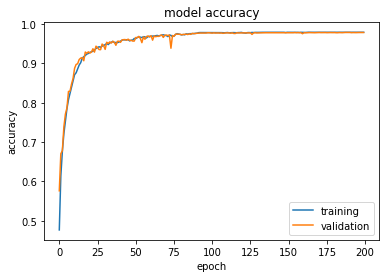

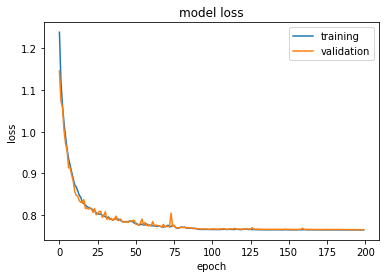

In [19]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Save the model

In [20]:
model_path = RESEARCH_WORK_PATH + 'models/multimodal_5s_0.5shift_200epoch_fixed_kernel.pth'
torch.save(model.state_dict(), model_path)

# 疑問点
入力画素数はどこでわかる？